# Adaptive Noise Canceller
**Written by:** Akwasi Akwaboah <br>
**Version 0.0:** 04/12/2021

Simulation of the adaptive noise canceller by Widrow et al. Prior to Hardware (Arduino) Implementation. Incorporates the LMS algorithm (similar to stochastic gradient descent). Adopts a Weiner filter approach but weights are optimized in real-time by the LMS, instead of solving the computationally expensive Weiner-Hopf type equation.

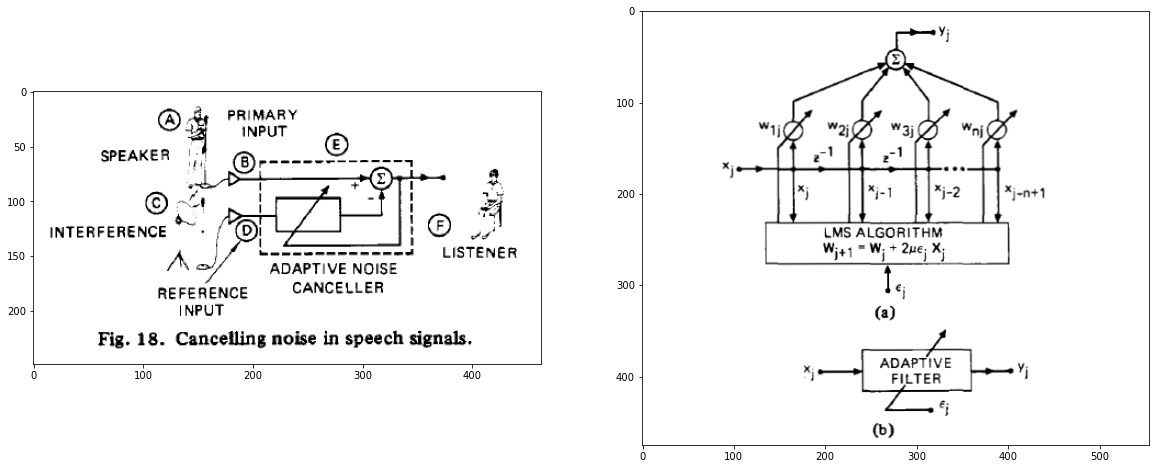

In [3]:
import matplotlib.pyplot as plt
A = plt.imread('ada_filter.PNG')
B = plt.imread('ada_filter_re.PNG')

plt.figure(figsize=(20,18))
plt.subplot(1, 2, 1)
plt.imshow(A)
plt.subplot(1, 2, 2)
plt.imshow(B)

## 1. Signal Generation

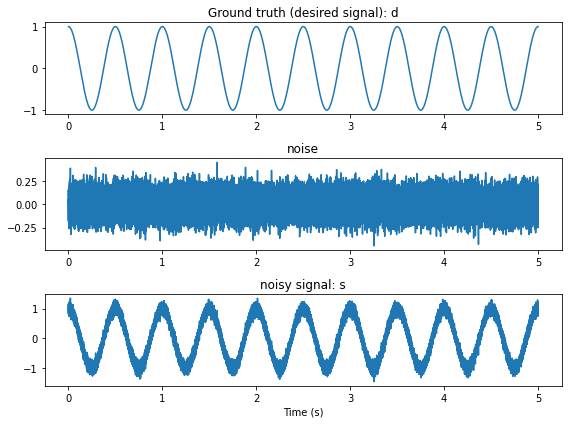

In [8]:
import numpy as np
# import matplotlib.pyplot as plt

np.random.seed(42)

k = 10e3 #[Hz] #sampling frequency
f = 2
n_samples = 10000*5
n = np.arange(0, n_samples)
d = np.cos(2*np.pi*f*(n/k))
noise = np.random.normal(0,0.1,n_samples)
s = d + noise

plt.figure(figsize=(8,6))
plt.subplot(3, 1, 1)
plt.plot(n/k, d)
plt.title('Ground truth (desired signal): d')
plt.subplot(3, 1, 2)
plt.plot(n/k, noise)
plt.title('noise')
plt.subplot(3, 1, 3)
plt.plot(n/k, s)
plt.title('noisy signal: s')
plt.xlabel('Time (s)')
plt.tight_layout()

## 2. Implementation of Algorithm
Input and output shown

---Iteration #: 0---
Adaptive filter weights: [0.00174558 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


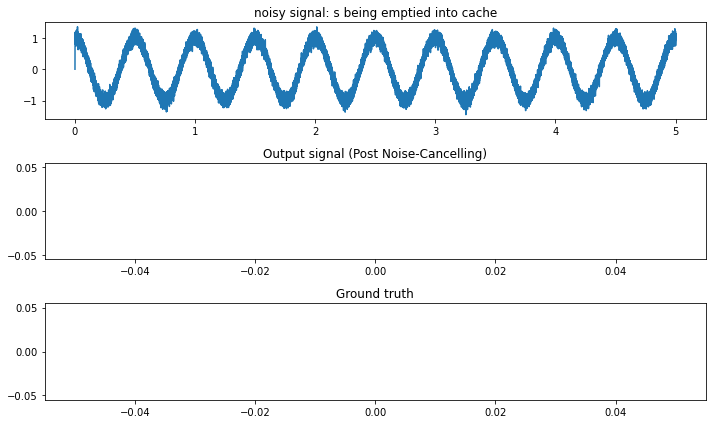

---Iteration #: 10000---
Adaptive filter weights: [0.67822281 0.04802676 0.04728551 0.05127828 0.05244269 0.05270091
 0.04656348 0.04568232 0.0413522  0.04063271 0.04597802 0.04803948
 0.0482522  0.04537936 0.04662646 0.04712169]


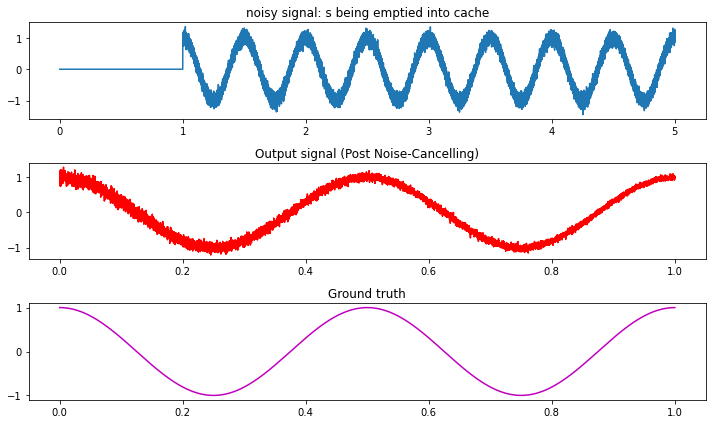

---Iteration #: 20000---
Adaptive filter weights: [0.92585288 0.0610716  0.06339786 0.06453462 0.0666287  0.06570376
 0.06294535 0.05919649 0.05900647 0.05921618 0.06194585 0.06134094
 0.06386034 0.06558128 0.06495345 0.06878127]


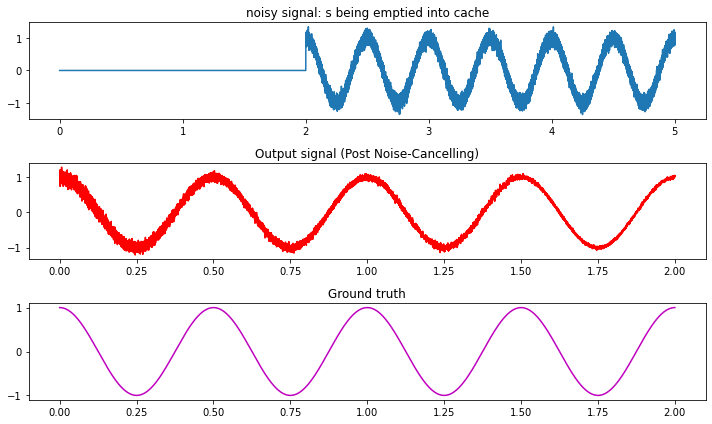

---Iteration #: 30000---
Adaptive filter weights: [0.97617497 0.02772802 0.02901178 0.02861133 0.02997194 0.0298594
 0.03056345 0.02977411 0.03186662 0.02994489 0.03124894 0.029323
 0.02921387 0.02812731 0.02863975 0.03004637]


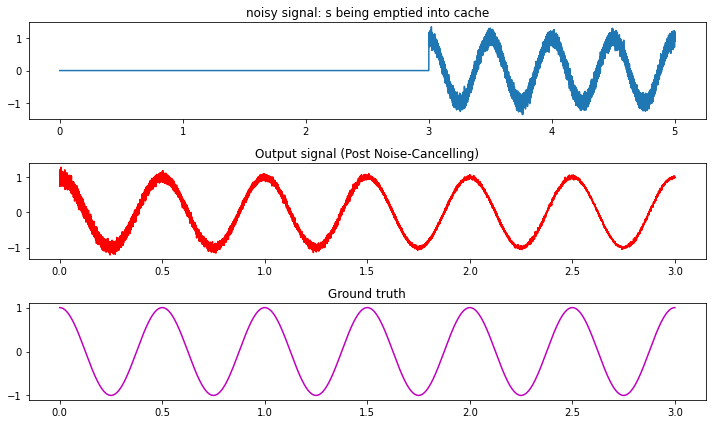

---Iteration #: 40000---
Adaptive filter weights: [ 0.94282189 -0.03968765 -0.03858156 -0.03878113 -0.03815076 -0.038082
 -0.03965967 -0.03954734 -0.0404589  -0.03968922 -0.03863574 -0.03966326
 -0.04020937 -0.04104287 -0.039642   -0.03897134]


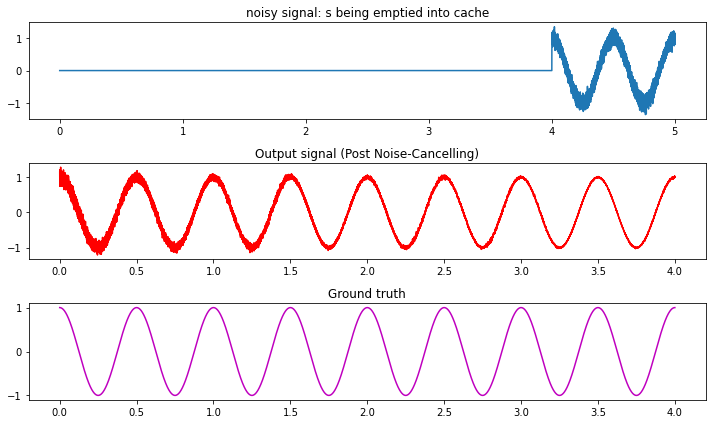

---Iteration #: 50000---
Adaptive filter weights: [ 0.93675557 -0.05787822 -0.05861616 -0.05881033 -0.06047538 -0.06043513
 -0.06041971 -0.06178911 -0.06262574 -0.06224708 -0.06260581 -0.06170943
 -0.06093778 -0.06160564 -0.05832877 -0.05573144]


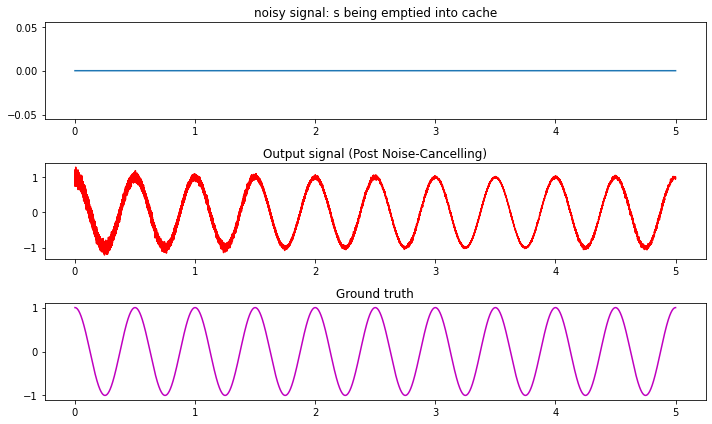

In [10]:
np.random.seed(42)

k = 10e3 #[Hz] #sampling frequency
f = 2
n_samples = 10000*5
n = np.arange(0, n_samples)
d = np.cos(2*np.pi*f*(n/k))
noise = np.random.normal(0,0.1,n_samples)
s = d + noise

w_count = 16 #16 byte cache -- each byte will hold a quantized weight for shifted signal sample
Cache = np.zeros(w_count) #x
Error = np.zeros(n_samples+1)
W = np.zeros(w_count)
mu = 0.5e-2 #learning rate
for i in range(n_samples+1):
    #update cache by shifting
    Cache = np.roll(Cache, 1) #shifting cache - equivalent to word shifts in hardware
    Cache[0] = noise[-1] #ensure no rotation
    noise = np.roll(noise, 1) 
    noise[0] = 0
    
    y = W.T@Cache #adaptive filter output
    e = s[-1] - y #output/ error
    W = W + 2*mu*e*Cache #LMS instead of Least square approach for the Weiner-Hopf equation
    Error[i] = e #Store for error for plot
    s = np.roll(s, 1) #for the next
    s[0] = 0
#   print(W)
    if i%(n_samples/5) == 0:
        print('---Iteration #: {}---'.format(i))
        print('Adaptive filter weights: {}'.format(W))
        plt.figure(figsize=(10,6))
        plt.subplot(3,1,1)
        plt.plot(n/k, s)
        plt.title('noisy signal: s being emptied into cache')
        plt.subplot(3,1,2)
        plt.plot(n[:i]/k, (Error[:i]), '-r')
        plt.title('Output signal (Post Noise-Cancelling)')
        plt.subplot(3,1,3)
        plt.plot(n[:i]/k, (d[:i]), '-m')
        plt.title('Ground truth')
        plt.tight_layout()
        plt.show()


## 3. Learning rate($\mu$) Experiments
Data exported as mat file to be analyzed together with hardware implementation

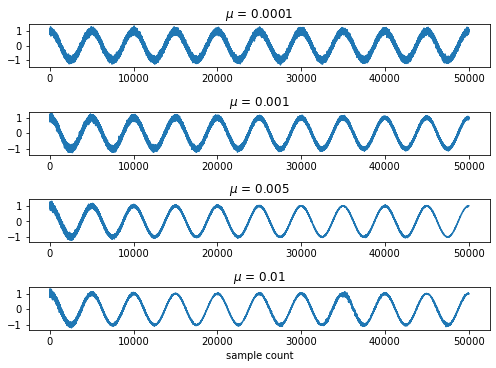

In [77]:
denoised_arr = np.zeros((5, n_samples))

np.random.seed(42)

k = 10e3 #[Hz] #sampling frequency
f = 2
n_samples = 10000*5
n = np.arange(0, n_samples)
mu_o = 1e-2 #learning rate
mu_arr = np.array([0.01, 0.1, 0.5, 1])*mu_o
j = 0
d_o = np.cos(2*np.pi*f*(n/k))
noise_o = np.random.normal(0,0.1,n_samples)
s_o = d_o + noise_o

plt.figure(figsize=(7,6))
for mu in mu_arr:
    d = np.cos(2*np.pi*f*(n/k))
    noise = np.random.normal(0,0.1,n_samples)
    s = d + noise

    w_count = 16 #16 byte cache -- each byte will hold a quantized weight for shifted signal sample
    Cache = np.zeros(w_count) #x
    Error = np.zeros(n_samples+1)
    W = np.zeros(w_count)
    for i in range(n_samples+1):
        #update cache by shifting
        Cache = np.roll(Cache, 1) #shifting cache - equivalent to word shifts in hardware
        Cache[0] = noise[-1] #ensure no rotation
        noise = np.roll(noise, 1) 
        noise[0] = 0

        y = W.T@Cache #adaptive filter output
        e = s[-1] - y #output/ error
        W = W + 2*mu*e*Cache #LMS instead of Least square approach for the Weiner-Hopf equation
        Error[i] = e #Store for error for plot
        s = np.roll(s, 1) #for the next
        s[0] = 0
    #   print(W)
    denoised_arr[j, :] = Error[:-1]
    plt.subplot(5, 1, j+1)
    plt.plot(n, denoised_arr[j])
    plt.title('$\mu$ = {}'.format(mu))
    j = j+1
plt.xlabel('sample count')
plt.tight_layout()
plt.savefig('denoised_sigs.png ', dpi=400)
plt.show()

Data Export (MATLAB format)Data Export (MATLAB format)

In [58]:
from scipy.io import savemat 

ANC_dat = {'t1': denoised_arr[0, :],
          't2': denoised_arr[1, :],
          't3': denoised_arr[2, :],
          't4': denoised_arr[3, :],
          'noise': noise_o,
          'noisy_sig': s_o,
          'desired': d_o}

savemat('ANC_data.mat', ANC_dat)

# f = open('ANC_data.pkl', 'wb')
# pickle.dump(denoised_arr, f)
# f.close()

## 4. Learning rate($N$) Experiments
Data exported as mat file to be analyzed together with hardware implementation

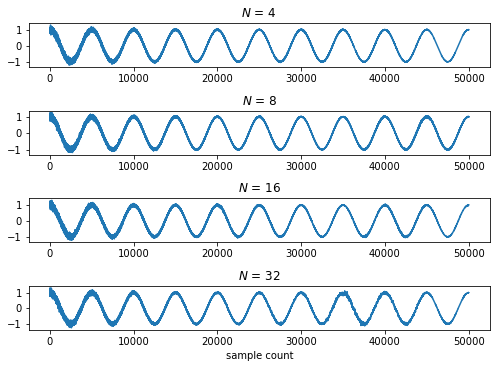

In [82]:
denoised_arr = np.zeros((5, n_samples))

np.random.seed(42)

k = 10e3 #[Hz] #sampling frequency
f = 2
n_samples = 10000*5
n = np.arange(0, n_samples)
mu_o = 1e-2 #learning rate
# mu_arr = np.array([0.01, 0.1, 0.5, 1])*mu_o
j = 0
d_o = np.cos(2*np.pi*f*(n/k))
noise_o = np.random.normal(0,0.1,n_samples)
s_o = d_o + noise_o
N_arr = np.array([4, 8, 16, 32])

plt.figure(figsize=(7,6))
for w_count in N_arr:
    d = np.cos(2*np.pi*f*(n/k))
    noise = np.random.normal(0,0.1,n_samples)
    s = d + noise
    mu = 0.5*mu_o
    Cache = np.zeros(w_count) #x
    Error = np.zeros(n_samples+1)
    W = np.zeros(w_count)
    for i in range(n_samples+1):
        #update cache by shifting
        Cache = np.roll(Cache, 1) #shifting cache - equivalent to word shifts in hardware
        Cache[0] = noise[-1] #ensure no rotation
        noise = np.roll(noise, 1) 
        noise[0] = 0

        y = W.T@Cache #adaptive filter output
        e = s[-1] - y #output/ error
        W = W + 2*mu*e*Cache #LMS instead of Least square approach for the Weiner-Hopf equation
        Error[i] = e #Store for error for plot
        s = np.roll(s, 1) #for the next
        s[0] = 0
    #   print(W)
    denoised_arr[j, :] = Error[:-1]
    plt.subplot(5, 1, j+1)
    plt.plot(n, denoised_arr[j])
    plt.title('$N$ = {}'.format(w_count))
    j = j+1
plt.xlabel('sample count')
plt.tight_layout()
plt.savefig('N_sigs.png', dpi=400)
plt.show()

Data Export (MATLAB format)

In [83]:
from scipy.io import savemat 

ANC_dat = {'t1': denoised_arr[0, :],
          't2': denoised_arr[1, :],
          't3': denoised_arr[2, :],
          't4': denoised_arr[3, :],
          'noise': noise_o,
          'noisy_sig': s_o,
          'desired': d_o}

savemat('ANC_data_N.mat', ANC_dat)

# f = open('ANC_data.pkl', 'wb')
# pickle.dump(denoised_arr, f)
# f.close()